<a href="https://colab.research.google.com/github/YazMRRS/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo

# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/YazMRRS/FisicaComputacional1/master/Actividad1/26086Diario.txt'
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_3=df_meteo_ts[(df_meteo_ts['Año']>=1924)&(df_meteo_ts['Año']<1927)]
df_33=df_meteo_ts[(df_meteo_ts['Año']>=1927)&(df_meteo_ts['Año']<1957)]
df_63=df_meteo_ts[(df_meteo_ts['Año']>=1957)&(df_meteo_ts['Año']<1987)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19169 entries, 1924-08-05 to 1987-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  19155 non-null  float64
 1   Evap    4123 non-null   float64
 2   Tmax    19062 non-null  float64
 3   Tmin    19067 non-null  float64
 4   Año     19169 non-null  int64  
 5   Mes     19169 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.0+ MB


In [20]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [21]:
#Creamos la primera serie de tiempo para analizar
#Fechas de inicio y fin, para filtrar la información
star, end= '1980-01', '1985-12'

ts_63 = df_63.loc[star:end].copy()
ts_63.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1980-01-01,0.0,NaN,19.0,8.0,1980,Jan
1980-01-02,0.0,NaN,21.0,9.2,1980,Jan
1980-01-03,0.0,NaN,23.0,8.0,1980,Jan
1980-01-04,0.0,NaN,21.0,8.0,1980,Jan
1980-01-05,0.0,NaN,22.0,4.0,1980,Jan


In [22]:
#Vemos su encabezado
ts_63['Tmax'].head()

Fecha
1980-01-01    19.0
1980-01-02    21.0
1980-01-03    23.0
1980-01-04    21.0
1980-01-05    22.0
Name: Tmax, dtype: float64

In [23]:
#Definimos la serie de tiempo con Tmax
ts_test = ts_63['Tmax'].copy()

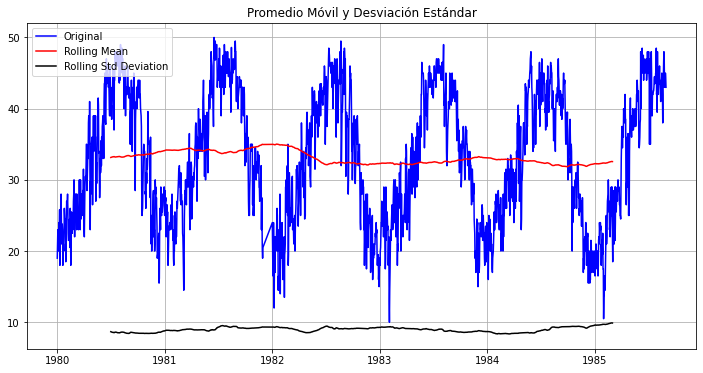

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.577938
p-value                           0.097643
#Lags Used                       16.000000
Number of Observations Used    2022.000000
Critical Value (1%)              -3.433588
Critical Value (5%)              -2.862970
Critical Value (10%)             -2.567532
dtype: float64


In [24]:
#Realizamos la prueba de estacionalidad de Tmax
test_stationarity(ts_test)

Notamos que el promedio móvil no es contantes y el valor p de ADF: p>0.05 (0.097643)

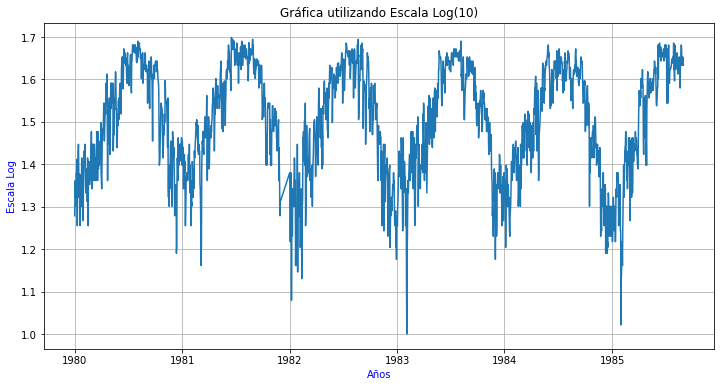

In [25]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

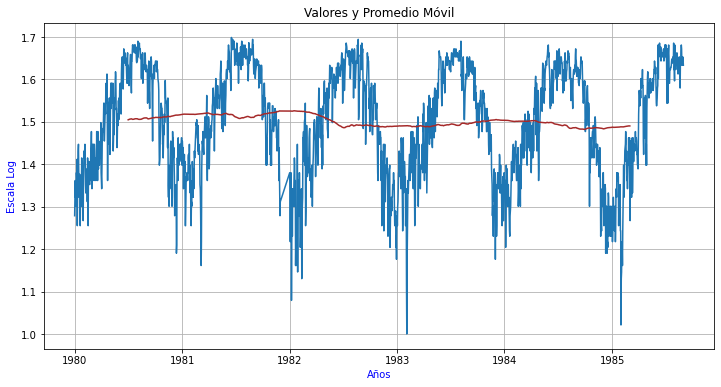

In [27]:
#Calculamos el promedio móvil con ventana de 365 y contrastamos con el de arriba
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [28]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
1980-01-01   NaN
1980-01-02   NaN
1980-01-03   NaN
1980-01-04   NaN
1980-01-05   NaN
Name: Tmax, dtype: float64

In [29]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
1980-07-01    0.128605
1980-07-02    0.091407
1980-07-03    0.101902
1980-07-04    0.079695
1980-07-05    0.101390
Name: Tmax, dtype: float64

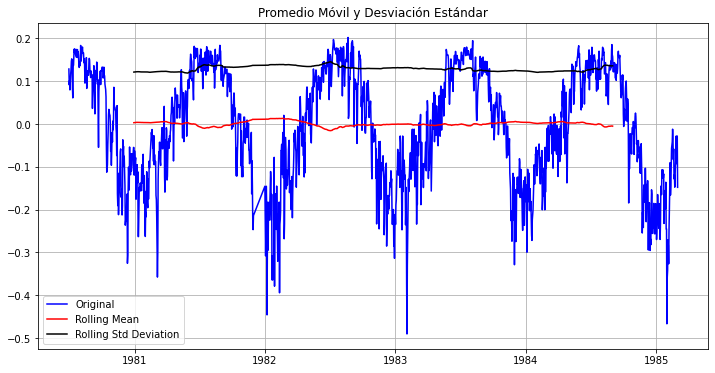

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.663979
p-value                           0.080481
#Lags Used                       15.000000
Number of Observations Used    1659.000000
Critical Value (1%)              -3.434298
Critical Value (5%)              -2.863284
Critical Value (10%)             -2.567698
dtype: float64


In [30]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

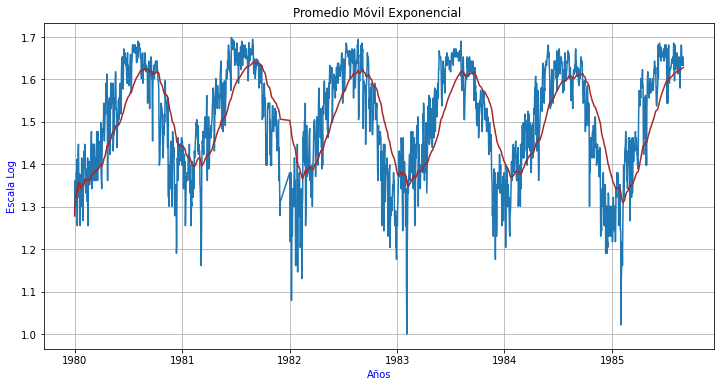

In [31]:
# Repetimos el cálculo usando promedios móviles exponenciales, 

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [32]:
EWM_avg.head()

Fecha
1980-01-01    1.278754
1980-01-02    1.300738
1980-01-03    1.321539
1980-01-04    1.321715
1980-01-05    1.326050
Name: Tmax, dtype: float64

In [33]:
#Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

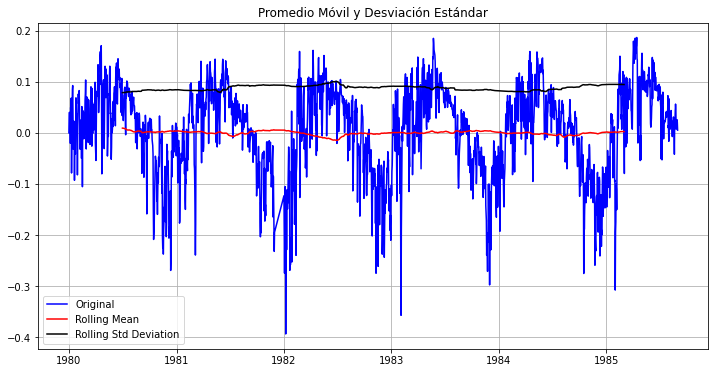

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.406021
p-value                           0.010755
#Lags Used                       20.000000
Number of Observations Used    2018.000000
Critical Value (1%)              -3.433595
Critical Value (5%)              -2.862973
Critical Value (10%)             -2.567533
dtype: float64


In [34]:
#Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

Ahora el valor de p < 0.05, es decir que podemos rechazar y la hipótesis nula de que la serie de tiempo no es estacionaria y afirmas que la serie de tiempo es estacionaria con 99% de confianza. 

Podemos decir que la serie es estacionaria, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.

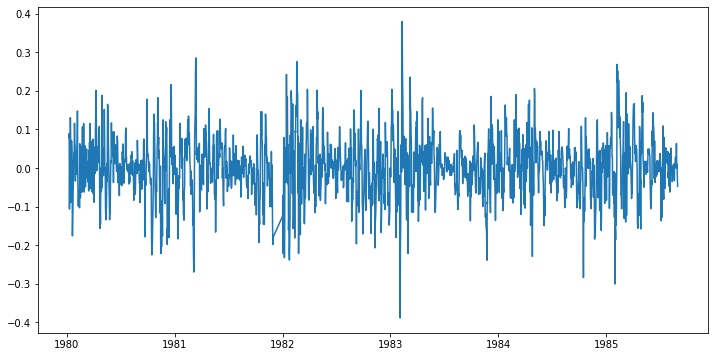

In [35]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

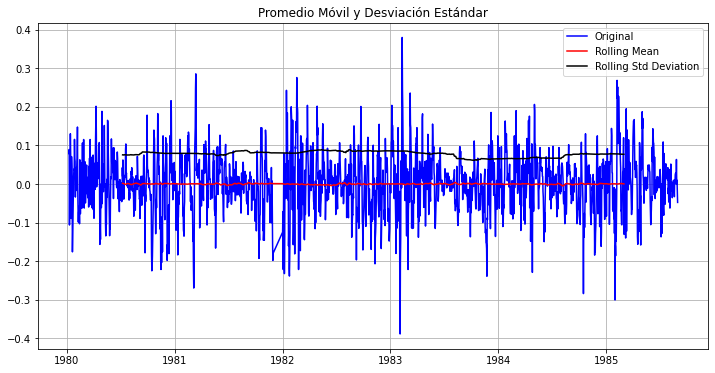

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.022477e+01
p-value                        5.211539e-18
#Lags Used                     2.100000e+01
Number of Observations Used    2.010000e+03
Critical Value (1%)           -3.433608e+00
Critical Value (5%)           -2.862979e+00
Critical Value (10%)          -2.567536e+00
dtype: float64


In [36]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [37]:
# Número de datos utilizados
len(ts_test_log_diff)

2032

Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho. Pero la estacionalidad domina.

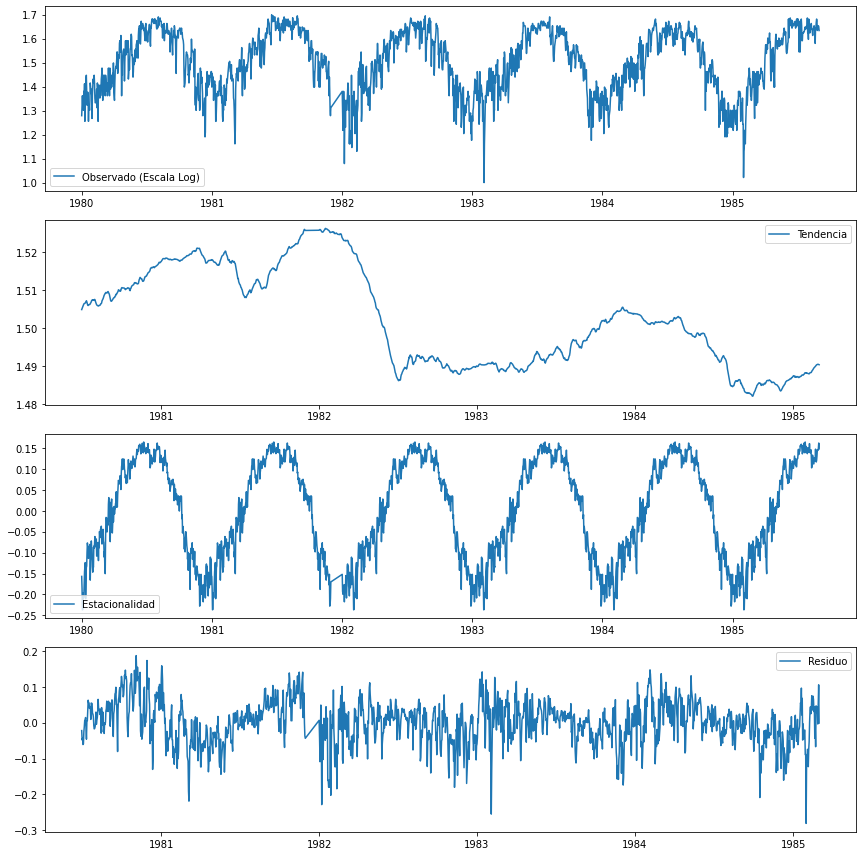

In [38]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

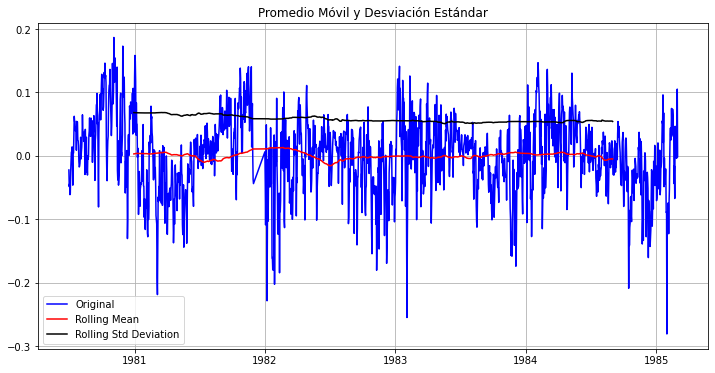

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -5.044674
p-value                           0.000018
#Lags Used                       20.000000
Number of Observations Used    1654.000000
Critical Value (1%)              -3.434310
Critical Value (5%)              -2.863289
Critical Value (10%)             -2.567701
dtype: float64


In [40]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no.
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

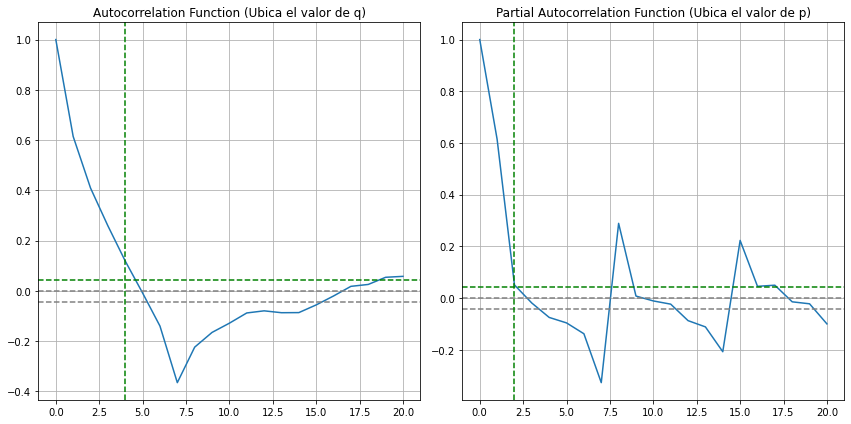

In [41]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

p=2 

q=4

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2038
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3352.364
Method:                       css-mle   S.D. of innovations              0.047
Date:                Sun, 28 Feb 2021   AIC                          -6696.729
Time:                        05:17:29   BIC                          -6674.250
Sample:                             1   HQIC                         -6688.483
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.001      0.238      0.812      -0.001       0.002
ar.L1.D.Tmax    -0.3023      0.022    -13.832      0.000      -0.345      -0.260
ar.L2.D.Tmax    -0.1630      0.022     -7.45

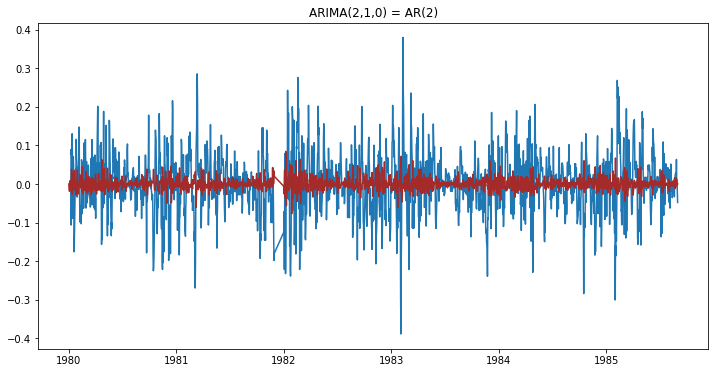

In [42]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2038
Model:                 ARIMA(0, 1, 4)   Log Likelihood                3398.790
Method:                       css-mle   S.D. of innovations              0.046
Date:                Sun, 28 Feb 2021   AIC                          -6785.580
Time:                        05:18:40   BIC                          -6751.861
Sample:                             1   HQIC                         -6773.211
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.463      0.643      -0.001       0.001
ma.L1.D.Tmax    -0.3672      0.022    -16.535      0.000      -0.411      -0.324
ma.L2.D.Tmax    -0.1400      0.023     -6.04

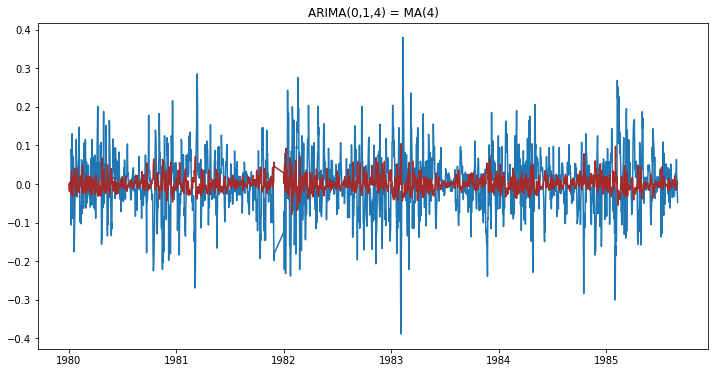

In [43]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overf

                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2038
Model:                 ARIMA(2, 1, 4)   Log Likelihood                3405.516
Method:                       css-mle   S.D. of innovations              0.045
Date:                Sun, 28 Feb 2021   AIC                          -6795.031
Time:                        05:19:27   BIC                          -6750.073
Sample:                             1   HQIC                         -6778.539
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.527      0.598      -0.000       0.001
ar.L1.D.Tmax    -0.3227      0.072     -4.479      0.000      -0.464      -0.182
ar.L2.D.Tmax     0.6410      0.072      8.96

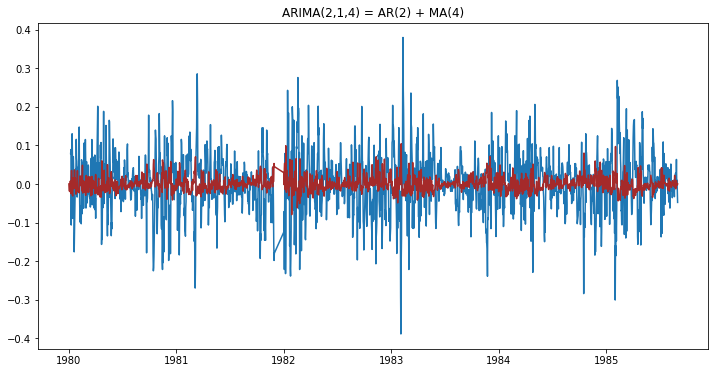

In [44]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [45]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000156
1980-01-03   -0.011108
1980-01-04   -0.018750
1980-01-05    0.000317
1980-01-06   -0.008117
                ...   
1985-08-27    0.008352
1985-08-28    0.000506
1985-08-29    0.001186
1985-08-30   -0.002954
1985-08-31    0.000307
Length: 2038, dtype: float64


In [46]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    1.322375
1980-01-03    1.350619
1980-01-04    1.303469
1980-01-05    1.342739
dtype: float64
Fecha
1985-08-27    1.651805
1985-08-28    1.643959
1985-08-29    1.654398
1985-08-30    1.645406
1985-08-31    1.633775
dtype: float64


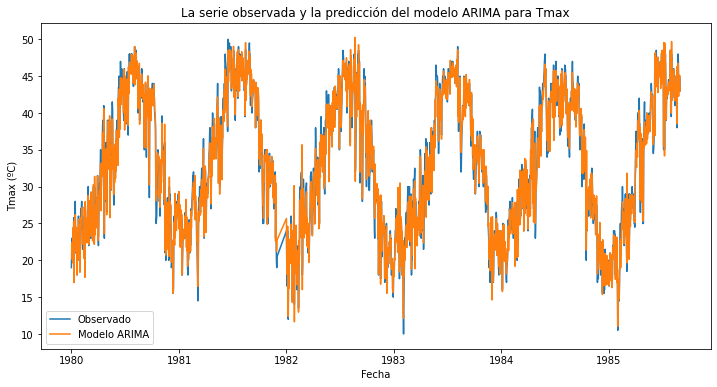

In [47]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [48]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 1.2135286279484452


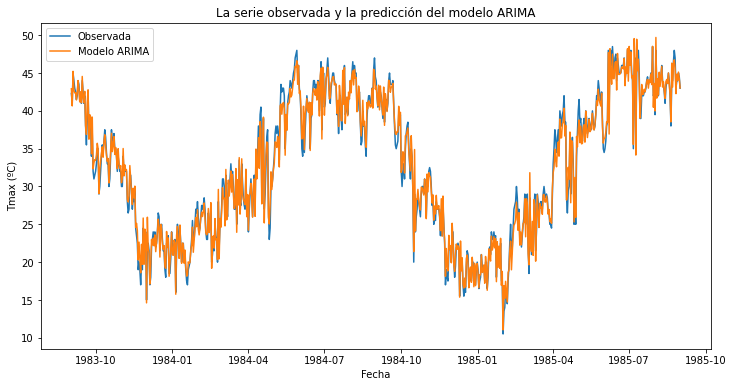

In [49]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');